# **Youtube Videos Transcription with OpenAI's Whisper**

[![blog post shield](https://img.shields.io/static/v1?label=&message=Blog%20post&color=blue&style=for-the-badge&logo=openai&link=https://openai.com/blog/whisper)](https://openai.com/blog/whisper)
[![notebook shield](https://img.shields.io/static/v1?label=&message=Notebook&color=blue&style=for-the-badge&logo=googlecolab&link=https://colab.research.google.com/github/ArthurFDLR/whisper-youtube/blob/main/whisper_youtube.ipynb)](https://colab.research.google.com/github/ArthurFDLR/whisper-youtube/blob/main/whisper_youtube.ipynb)
[![repository shield](https://img.shields.io/static/v1?label=&message=Repository&color=blue&style=for-the-badge&logo=github&link=https://github.com/openai/whisper)](https://github.com/openai/whisper)
[![paper shield](https://img.shields.io/static/v1?label=&message=Paper&color=blue&style=for-the-badge&link=https://cdn.openai.com/papers/whisper.pdf)](https://cdn.openai.com/papers/whisper.pdf)
[![model card shield](https://img.shields.io/static/v1?label=&message=Model%20card&color=blue&style=for-the-badge&link=https://github.com/openai/whisper/blob/main/model-card.md)](https://github.com/openai/whisper/blob/main/model-card.md)

Whisper is a general-purpose speech recognition model. It is trained on a large dataset of diverse audio and is also a multi-task model that can perform multilingual speech recognition as well as speech translation and language identification.

This notebook will guide you through the transcription of a Youtube video using Whisper. You'll be able to explore most inference parameters or use the Notebook as-is to store the transcript and the audio of the video in your Google Drive.

In [1]:
#@markdown #**Check GPU type** 🕵️

#@markdown The type of GPU you get assigned in your Colab session defined the speed at which the video will be transcribe.
#@markdown The higher the number of floating point operations per second (FLOPS), the faster the transcription.
#@markdown But even the least powerful GPU available in Colab is able to run any Whisper model.
#@markdown Make sure you've selected `GPU` as hardware accelerator for the Notebook (Runtime &rarr; Change runtime type &rarr; Hardware accelerator).

#@markdown |  GPU   |  GPU RAM   | FP32 teraFLOPS |     Availability   |
#@markdown |:------:|:----------:|:--------------:|:------------------:|
#@markdown |  T4    |    16 GB   |       8.1      |         Free       |
#@markdown | P100   |    16 GB   |      10.6      |      Colab Pro     |
#@markdown | V100   |    16 GB   |      15.7      |  Colab Pro (Rare)  |

#@markdown ---
#@markdown **Factory reset your Notebook's runtime if you want to get assigned a new GPU.**

!nvidia-smi -L

!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-9ba4ce04-e020-44f9-8fc3-337ba5bb5496)
Sun Oct  2 16:49:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                       

In [2]:
#@markdown #**Install libraries** 🏗️
#@markdown This cell will take a little while to download several libraries, including Whisper.

#@markdown ---

! pip install git+https://github.com/openai/whisper.git
! pip install pytube

import sys
import whisper
from pathlib import Path
import pytube
import subprocess
import torch
import shutil

# import io
# import os, time, glob
# import pickle
# import shutil
# import numpy as np
# from PIL import Image
# import unicodedata
# import re
# from tqdm.notebook import tqdm
from IPython.display import display, Markdown, YouTubeVideo
# from google.colab import files

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-c3voj3wy
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-c3voj3wy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Using device: cuda:0


In [3]:
#@markdown #**Optional:** Save images in Google Drive 💾
# @markdown Enter a Google Drive path and run this cell if you want to store the results inside Google Drive.

# Uncomment to copy generated images to drive, faster than downloading directly from colab in my experience.
from google.colab import drive
drive_mount_path = Path("/") / "content" / "drive"
drive.mount(str(drive_mount_path))
drive_mount_path /= "My Drive"
#@markdown ---
drive_path = "Colab Notebooks/Whisper Youtube" #@param {type:"string"}
#@markdown ---
#@markdown **Run this cell again if you change your Google Drive path.**

drive_whisper_path = drive_mount_path / Path(drive_path.lstrip("/"))
drive_whisper_path.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


In [4]:
#@markdown #**Model selection** 🧠

#@markdown As of the first public release, there are 4 pre-trained options to play with:

#@markdown |  Size  | Parameters | English-only model | Multilingual model | Required VRAM | Relative speed |
#@markdown |:------:|:----------:|:------------------:|:------------------:|:-------------:|:--------------:|
#@markdown |  tiny  |    39 M    |     `tiny.en`      |       `tiny`       |     ~1 GB     |      ~32x      |
#@markdown |  base  |    74 M    |     `base.en`      |       `base`       |     ~1 GB     |      ~16x      |
#@markdown | small  |   244 M    |     `small.en`     |      `small`       |     ~2 GB     |      ~6x       |
#@markdown | medium |   769 M    |    `medium.en`     |      `medium`      |     ~5 GB     |      ~2x       |
#@markdown | large  |   1550 M   |        N/A         |      `large`       |    ~10 GB     |       1x       |

#@markdown ---
Model = 'large' #@param ['tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large']
#@markdown ---
#@markdown **Run this cell again if you change the model.**

whisper_model = whisper.load_model(Model)

if Model in whisper.available_models():
    display(Markdown(
        f"**{Model} model is selected.**"
    ))
else:
    display(Markdown(
        f"**{Model} model is no longer available.**<br /> Please select one of the following:<br /> - {'<br /> - '.join(whisper.available_models())}"
    ))

100%|█████████████████████████████████████| 2.87G/2.87G [01:14<00:00, 41.5MiB/s]


**large model is selected.**

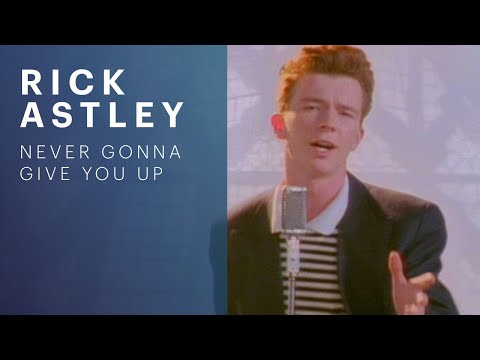

In [5]:
#@markdown #**Video selection** 📺

#@markdown Enter the URL of the Youtube video you want to transcribe, wether you want to save the audio file in your Google Drive, and run the cell.

#@markdown ---
URL = "https://youtu.be/dQw4w9WgXcQ" #@param {type:"string"}
store_audio = True #@param {type:"boolean"}
#@markdown ---
#@markdown **Run this cell again if you change the video.**

video_yt = pytube.YouTube(URL)

try:
    video_yt.check_availability()
    display(
        YouTubeVideo(video_yt.video_id)
    )
except pytube.exceptions.VideoUnavailable:
    display(
        Markdown(f"**{URL} isn't available.**"),
    )


video_path_local = Path(".").resolve() / (video_yt.video_id+".wav")
video_yt.streams.filter(
    type="audio",
    mime_type="audio/mp4",
    abr="48kbps"
).first().download(
    output_path = video_path_local.parent,
    filename = video_path_local.name
)

result = subprocess.run(["ffmpeg", "-i", str(video_path_local.with_suffix(".mp4")), "-vn", "-acodec", "pcm_s16le", "-ar", "16000", "-ac", "1", str(video_path_local)])

if store_audio:
    shutil.copy(video_path_local, drive_whisper_path / video_path_local.name)

In [6]:
#@markdown #**Run the model** 🚀

#@markdown Run this cell to execute the transcription of the video. This can take a while and very based on the length of the video and the number of parameters of the model selected above.

#@markdown ---
Language = "English" #@param {type:"string"}
# save_transcription = True #@param {type:"boolean"}
Output_type = '.vtt' #@param ['.txt', '.vtt', '.srt']
#@markdown ---

language = None if not Language else Language

video_transcription = whisper_model.transcribe(
    str(video_path_local),
    verbose=True,
    language=language
)

writing_lut = {
    '.txt': whisper.utils.write_txt,
    '.vtt': whisper.utils.write_vtt,
    '.srt': whisper.utils.write_txt,
}

transcript_local_path = video_path_local.with_suffix(Output_type)

with open(transcript_local_path, "w", encoding="utf-8") as f:
    writing_lut[Output_type](video_transcription["segments"], file=f)
try:
    transcript_drive_path = drive_whisper_path / transcript_local_path.name
    shutil.copy(transcript_local_path, transcript_drive_path)
    display(Markdown(f"**Transcript file created: {transcript_drive_path}**"))
except:
    display(Markdown(f"**Transcript file created: {transcript_local_path}**"))

[00:00.000 --> 00:22.000]  We're no strangers to love.
[00:22.000 --> 00:27.000]  You know the rules, and so do I.
[00:27.000 --> 00:31.000]  Our full commitments while I'm thinking of.
[00:31.000 --> 00:35.000]  You wouldn't get this from any other guy.
[00:35.000 --> 00:40.000]  I just wanna tell you how I'm feeling.
[00:40.000 --> 00:43.000]  Gotta make you understand.
[00:43.000 --> 00:45.000]  Never gonna give you up.
[00:45.000 --> 00:47.000]  Never gonna let you down.
[00:47.000 --> 00:51.000]  Never gonna run around and desert you.
[00:51.000 --> 00:53.000]  Never gonna make you cry.
[00:53.000 --> 00:55.000]  Never gonna say goodbye.
[00:55.000 --> 01:00.000]  Never gonna tell a lie and hurt you.
[01:00.000 --> 01:04.000]  We've known each other for so long.
[01:04.000 --> 01:09.000]  Your heart's been aching, but you're too shy to say it.
[01:09.000 --> 01:13.000]  Inside we both know what's been going on.
[01:13.000 --> 01:17.000]  We know the game and we're gonna play it.
[

**Transcript file created: /content/drive/My Drive/Colab Notebooks/Whisper Youtube/dQw4w9WgXcQ.vtt**